In [1]:
import pandas as pd
import numpy as np

In [2]:
if __name__ == '__main__':
    from findatapy.util import SwimPool; SwimPool()

    from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

    market = Market(market_data_generator=MarketDataGenerator())

    md_request = MarketDataRequest(
        start_date="01 Jun 2000",
        data_source='fred',tickers=['DGS10'],
        fields=['close'],
        vendor_tickers=['DGS10'], 
        vendor_fields=['close'])
    
    df = market.fetch_market(md_request)

2017-08-24 18:38:06,471 - findatapy.market.datavendorweb - INFO - Request Pandas Web data
2017-08-24 18:38:09,173 - findatapy.market.datavendorweb - INFO - Completed request from Pandas Web.
2017-08-24 18:38:09,200 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_359__abstract_curve_key-None__category-None__category_key-backtest_default-cat_fred_daily_NYC__cut-NYC__data_source-fred__environment-backtest__expiry_date-None__fields-close__finish_date-2017-08-24 09:38:05_671322__freq-daily__freq_mult-1__gran_freq-None__start_date-2000-06-01 00:00:00__tickers-DGS10__trade_side-trade__vendor_fields-close__vendor_tickers-DGS10 to Redis: Error 61 connecting to 127.0.0.1:6379. Connection refused.


In [3]:
df = df.reset_index()
df = df.rename(columns={'Date':'ds','DGS10.close':'y'})
df['y'] = np.log(df['y'])
df.head()

,ds,y
0,2000-06-01,1.824549
1,2000-06-02,1.816452
2,2000-06-05,1.811562
3,2000-06-06,1.814825
4,2000-06-07,1.813195


In [4]:
#　Make Prediction Model
from fbprophet import Prophet
model = Prophet(weekly_seasonality=True)
model.fit(df)

In [5]:
future_df = model.make_future_dataframe(200*5)
future_df.tail()

,ds
5489,2020-05-14
5490,2020-05-15
5491,2020-05-16
5492,2020-05-17
5493,2020-05-18


In [6]:
forecast_df = model.predict(future_df)
forecast_df[['ds','yhat']].tail()

,ds,yhat
5489,2020-05-14,0.496327
5490,2020-05-15,0.493613
5491,2020-05-16,0.500545
5492,2020-05-17,0.500130
5493,2020-05-18,0.494154


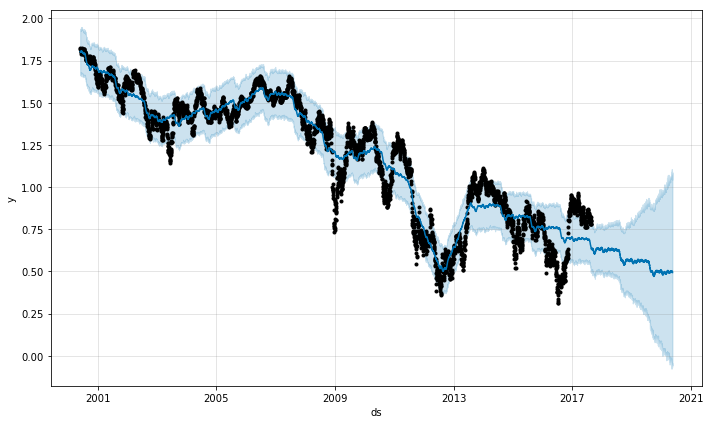

In [7]:
model.plot(forecast_df)
plt.show()